In [1]:
import torch, timm, AutoAugment
from torchvision.transforms import transforms
from softdataset import TripletImageDataset, data_split
from original_dataset import OriginalImageDataset, OriginalDataset, data_split, OriginalDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import transforms
import glob, os, random, json
from dataset import TripleDataset
from torch.nn import *
from collections import OrderedDict as OD
from tqdm import tqdm
import numpy as np
from PIL import Image
from sketch_dataset import SketchyImageDataset, SketchyDataset
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Inference with Sketchy Database (category based accuracy)

In [2]:
def get_fm(fm):
        pool = AvgPool2d((fm.shape[2],fm.shape[3]))
        return torch.reshape(pool(fm), (-1, fm.shape[1]))

def get_dl(path, bs, random = True, trainval_json="", trainval="val"):        
    
    ''' 
    Get path to the images and returns dataloader with transformations applied
    Arguments:

    path - path to the dir with images;
    bs - batch_size;
    random - if False loads train test split json file else randomly mix dataset.      

    '''
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([
                            transforms.Resize((224,224)),
                            # transforms.RandomHorizontalFlip(),
                            # transforms.RandomRotation(90, fill = fill),
                            # transforms.ColorJitter([0.3, 1]),
                            # transforms.GaussianBlur(9, (0.5, 3.0)),
                            # AutoAugment.ImageNetPolicy(),
                            transforms.ToTensor(),
                                                  ])

    transformations['pos'] = transforms.Compose([
        transforms.Resize((224,224)),
        # AutoAugment.ImageNetPolicy(),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])  
    transformations['neg'] = transforms.Compose([
        transforms.Resize((224,224)),
        # AutoAugment.ImageNetPolicy(),
        # transforms.RandomRotation(90, fill = fill_sketch),
        # transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])
    
    out_path = "data/sketchy_database_256_soft_split_cat.json"
    # out_path = "data/spec72.json"
    # out_path = data_split(path, out_path)

    # tr_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='train', load_images=False)
    # val_ds = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval='val', load_images=False)
    ds = SketchyDataset(data_dir = path, random=True, trainval_json=out_path, trainval='test')
    dataset = SketchyImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval=trainval, load_images=False)
    # ds = OriginalDataset(data_dir = path, random=True)
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([transforms.ToTensor()])
    transformations['pos'] = transforms.Compose([transforms.ToTensor()])
    transformations['neg'] = transforms.Compose([transforms.ToTensor()])
    
    # dataset = OriginalImageDataset(data_dir = path, transform_dic=transformations, random=True, load_images=False)
    num_classes = dataset.get_cat_length()
    print(f"The dataset has {num_classes} classes")    
    print(f"Number of test samples: {len(dataset)}")
    
    test_dl = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset, test_dl, ds


def load_checkpoint(checkpoint_path, model_name, device, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=device)
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                # model.head.fc = Identity()
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OD()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150", num_classes=num_classes)
                state_dict = torch.load(checkpoint_path, map_location=device)
                model.load_state_dict(state_dict)
                # num_features = model.head.fc.in_features
                # model.classifier = Linear(num_features, num_classes) if num_classes > 0 else Identity() 
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Inference using trained model and test dataloader.
        Arguments:
        
        model - trained model from the checkpoint (see load_checkpoint function);
        dataloader - test dataloader (see get_dl function);
        device - gpu device.
        
        '''   
        
        ims, poss, negs, pos_scores, neg_scores, fms_ims_all, top_vals, scores, fms_poss_all, fms_negs_all,  classes_all, top_inds, top_r_list, pred_lbls_all = [], [], [], [], [], [], [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        # model.head = Identity()
        
        print("Obtaining embeddings...")        
        for i, batch_all in tqdm(enumerate(dataloader)):
            # if i == 1:
            #     break
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            negs.extend(negs_all)
            classes_all.extend(clss_all.to(device)) 
            
            with torch.no_grad():
                
                # with torch.cuda.amp.autocast():
                fm_ims_all = model.forward_features(ims_all.to(device))            
                # lbl_ims_all = model.head(fm_ims_all)
                fm_poss_all = model.forward_features(poss_all.to(device))
                # lbl_poss_all = model.head(fm_poss_all)
                fm_negs_all = model.forward_features(negs_all.to(device))
                # lbl_negs_all = model.head(fm_negs_all)
                fm_ims_all = get_fm(fm_ims_all)
                fm_poss_all = get_fm(fm_poss_all)
                fm_negs_all = get_fm(fm_negs_all)
                fms_ims_all.extend(fm_ims_all) #bs, fm 
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)

        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all) 
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        negs = torch.stack(negs)        
        classes_all = torch.stack(classes_all)
        
        
        for idx, (gt_reg, fm) in enumerate(zip(classes_all, fms_ims_all)):
            pos_score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(len(dl))
            pos_scores.append(pos_score.item())
            neg_score = cos(fm.unsqueeze(0), fms_negs_all[idx].unsqueeze(0)) #(len(dl))
            neg_scores.append(neg_score.item())
            # print(f"\nCosine similarity of a qry image with the corresponding pos sketch image: {pos_score.item():.3f}")
            # print(f"Cosine similarity of a qry image with the corresponding neg sketch image: {neg_score.item():.3f}")
            vals, inds = torch.topk(cos(fm, fms_poss_all), k=150)
            
            classes = [int(classes_all[int(ind)]) for ind in inds]
            top_i, top_v, top_r, top_c = [], [], [], []
            
            for num, (i, v, r) in enumerate(zip(inds, vals, classes)):
                if r not in top_r:
                    top_r.append(r)
                    top_v.append(v)
                    top_i.append(int(i))
                if len(top_r) == 3:
                    break
            top3 += 1 if int(gt_reg) in top_r else 0
            top1 += 1 if int(gt_reg) == top_r[0] else 0
            
            top_inds.append(top_i)
            top_vals.append(top_v)
            top_r_list.append(top_r)        
            
        return OD([('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), ('scores', torch.mean(torch.FloatTensor(pos_scores))),
                    ('fms_ims_all', fms_ims_all), ('classes_all', classes_all), ('fms_poss_all', fms_poss_all),
                    ('ims', ims), ('poss', poss), ('negs', negs), ('fms_negs_all', fms_negs_all),
                    ('topk_inds_reg', top_r_list), ('topk_inds', top_inds), ('top_vals', top_vals), ('top_r_list', top_r_list)])

# Trained using contrastive, cosineembedding, and crossentropy losses (margin 0.3)

In [3]:
path = "/home/ubuntu/workspace/dataset/sketchy_database_256"
# path = "/home/ubuntu/workspace/dataset/test_dataset_svg/spec69"
bs=32
device='cuda:2'
num_classes, test_ds, test_dl, ds = get_dl(path=path, bs=bs, trainval='test')
idx_to_clss = {v:k for k,v in test_ds.cat_idx.items()}
checkpoint_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/saved_models/efficientnet_b3a_Adam_0.0047863/Sketchy-Dataset-Training/14ht8tb2/checkpoints/epoch=48-val_loss=0.40-cos_sims=0.95-val_top1=0.96.ckpt"
m = load_checkpoint(checkpoint_path, device=device, num_classes=125, from_pytorch_lightning=True, model_name='efficientnet_b3a')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 125 classes
Number of test samples: 12500
Model with init_conv False
Model efficientnet_b3a trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


390it [01:34,  4.11it/s]


Embeddings are obtained!
Calculating metrics...


(0.967948717948718, 0.9443108974358975, tensor(0.9380))


	Input Image			  GradCAM


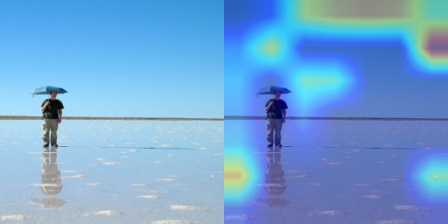


    Positive (Sketch) Image
	  Class: umbrella


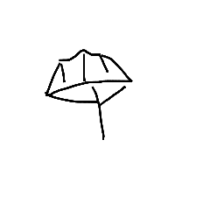


					Predicted Images
					   Grad CAM



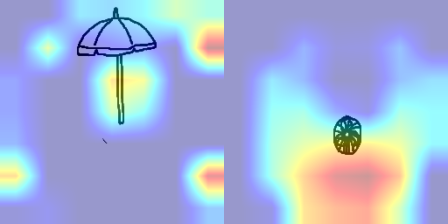

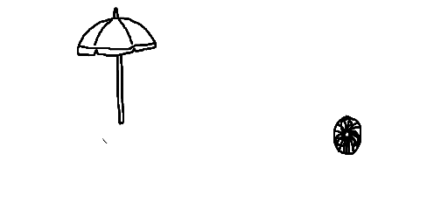


	Input Image			  GradCAM


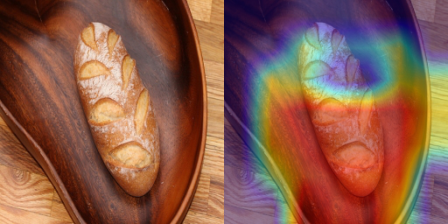


    Positive (Sketch) Image
	  Class: bread


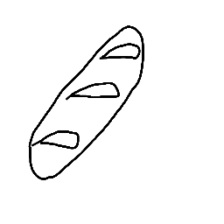


					Predicted Images
					   Grad CAM



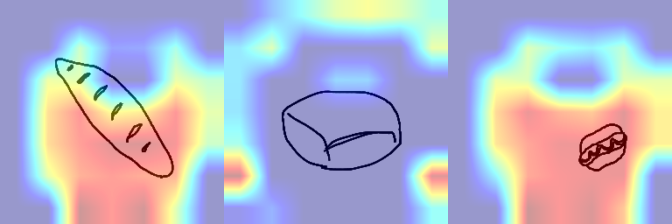

	cos_sim:0.983 			cos_sim:0.699 			cos_sim:0.650
	pred_class: bread 		pred_class: couch 		pred_class: hotdog


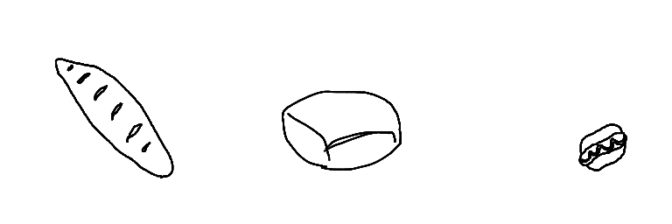


	Input Image			  GradCAM


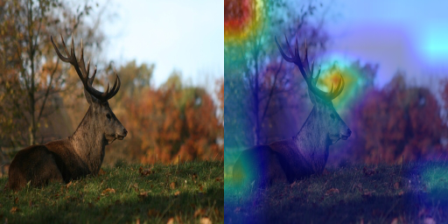


    Positive (Sketch) Image
	  Class: deer


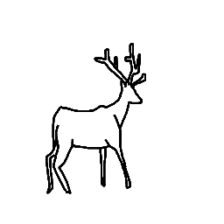


					Predicted Images
					   Grad CAM



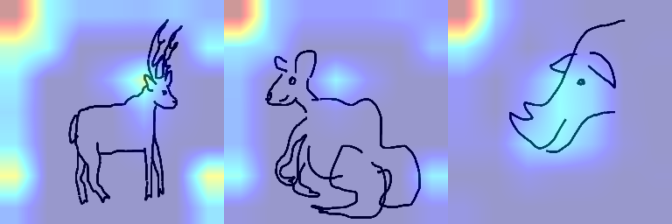

	cos_sim:0.995 			cos_sim:0.579 			cos_sim:0.573
	pred_class: deer 		pred_class: kangaroo 		pred_class: rhinoceros


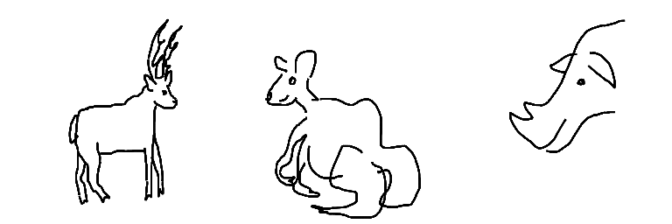


	Input Image			  GradCAM


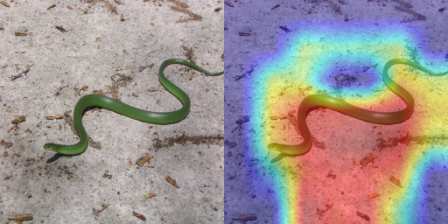


    Positive (Sketch) Image
	  Class: snake


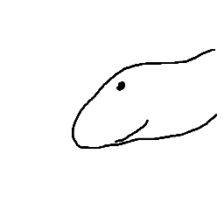


					Predicted Images
					   Grad CAM



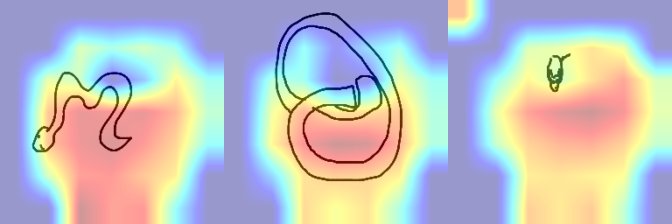

	cos_sim:0.997 			cos_sim:0.548 			cos_sim:0.494
	pred_class: snake 		pred_class: pretzel 		pred_class: mouse


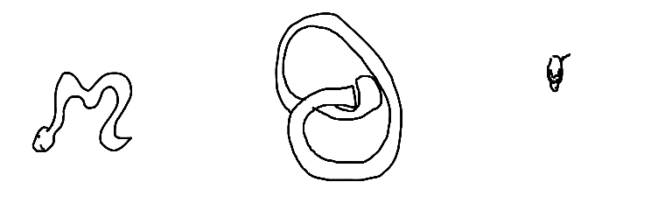


	Input Image			  GradCAM


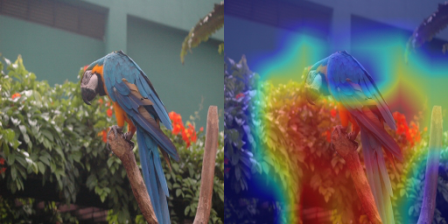


    Positive (Sketch) Image
	  Class: parrot


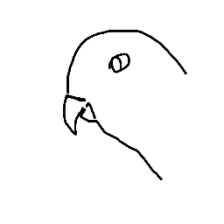


					Predicted Images
					   Grad CAM



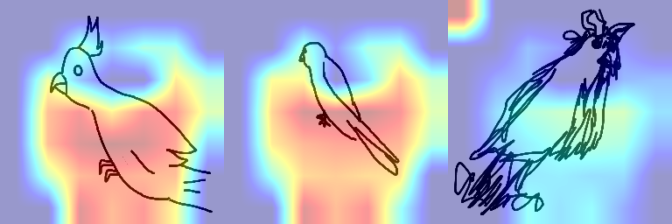

	cos_sim:0.998 			cos_sim:0.672 			cos_sim:0.665
	pred_class: parrot 		pred_class: songbird 		pred_class: chicken


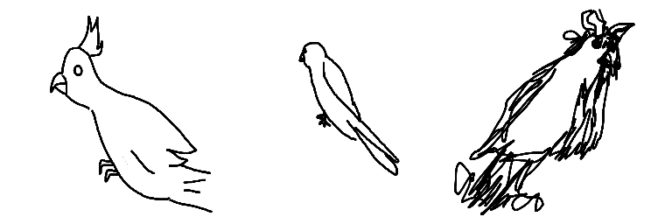


	Input Image			  GradCAM


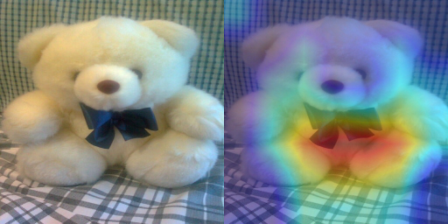


    Positive (Sketch) Image
	  Class: teddy_bear


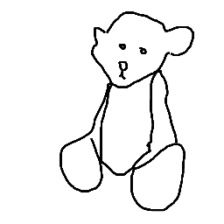


					Predicted Images
					   Grad CAM



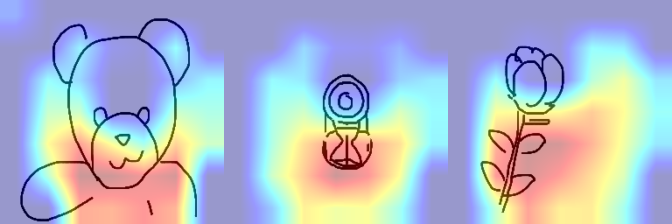

	cos_sim:0.956 			cos_sim:0.823 			cos_sim:0.722
	pred_class: teddy_bear 		pred_class: hourglass 		pred_class: flower


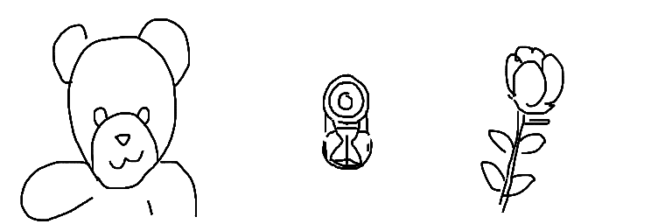


	Input Image			  GradCAM


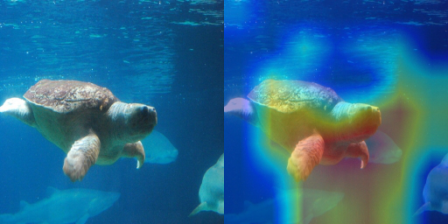


    Positive (Sketch) Image
	  Class: sea_turtle


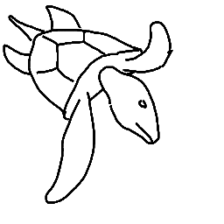


					Predicted Images
					   Grad CAM



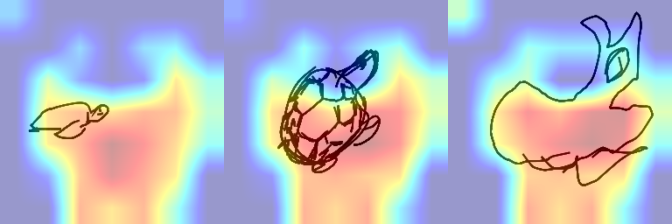

	cos_sim:0.996 			cos_sim:0.853 			cos_sim:0.673
	pred_class: sea_turtle 		pred_class: turtle 		pred_class: rabbit


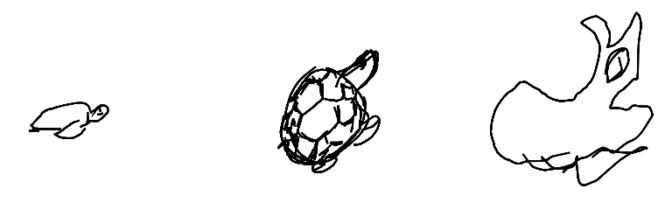


	Input Image			  GradCAM


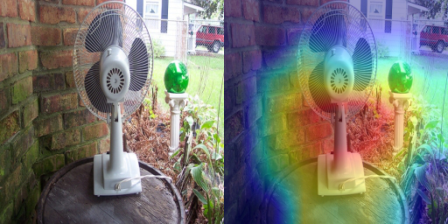


    Positive (Sketch) Image
	  Class: fan


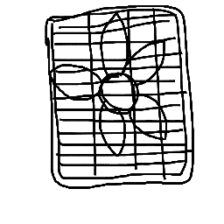


					Predicted Images
					   Grad CAM



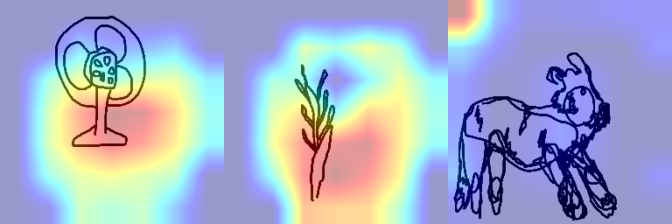

	cos_sim:0.994 			cos_sim:0.603 			cos_sim:0.552
	pred_class: fan 		pred_class: flower 		pred_class: tiger


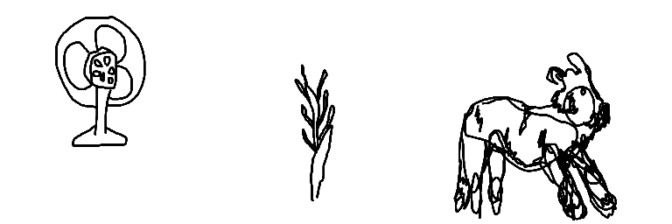


	Input Image			  GradCAM


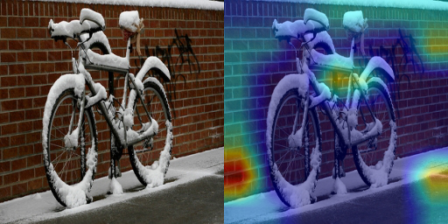


    Positive (Sketch) Image
	  Class: bicycle


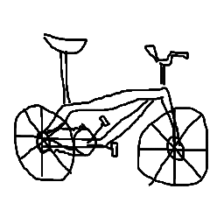


					Predicted Images
					   Grad CAM



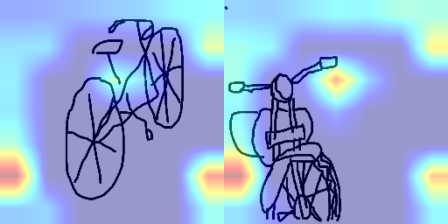

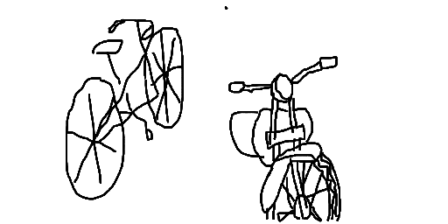


	Input Image			  GradCAM


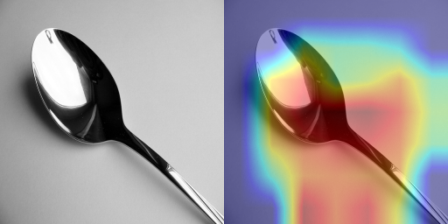


    Positive (Sketch) Image
	  Class: spoon


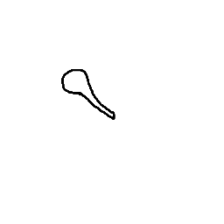


					Predicted Images
					   Grad CAM



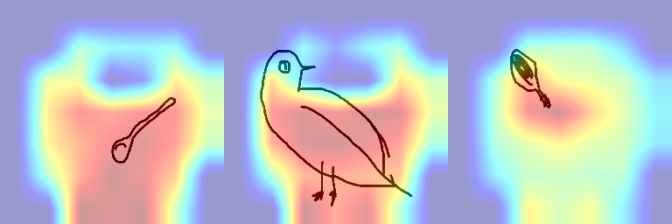

	cos_sim:0.988 			cos_sim:0.562 			cos_sim:0.562
	pred_class: spoon 		pred_class: songbird 		pred_class: racket


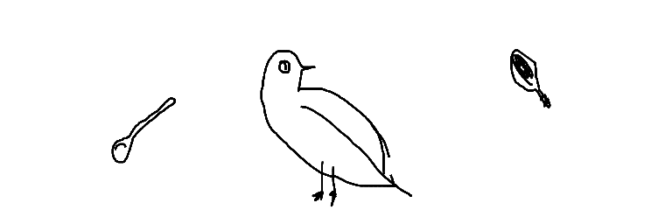

In [4]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
all_classes = results['classes_all']
poss = results['poss']
negs = results['negs']
indices_all = results["topk_inds"]
values_all = results["top_vals"]
classes_all = results["top_r_list"]

cnt = 0

m.to(device)
m.eval()
cam = GradCAM(model=m, target_layers=[m.conv_head])


for i, im in enumerate(ims):
    if i == 10:
        break
    print('\n\tInput Image\t\t\t  GradCAM')
    im_fm = get_fm(m.forward_features(im.unsqueeze(0).to(device)))
    grayscale_cam = cam(input_tensor=im.unsqueeze(0).to(device))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image((ims[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)/255, grayscale_cam, image_weight=0.6, use_rgb = True)
    ori_im = (ims[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
    display(Image.fromarray(np.concatenate([ori_im,visualization], axis=1)))
    print('\n    Positive (Sketch) Image')
    print(f"\t  Class: {idx_to_clss[all_classes[i].item()]}")
    display(Image.fromarray((poss[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1

    img_list = []
    img_list_gt = []
    pil_visualization = []
    for j in indices_all[i][:15]:
        img = (poss[j]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        oris = poss[j]
        ori_cam = ((oris)*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8) / 255
        grayscale_cam = cam(input_tensor=oris.unsqueeze(0).to(device))
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(ori_cam, grayscale_cam, image_weight=0.6, use_rgb = True)
        pil_visualization.append(visualization)
    print('\n\t\t\t\t\tPredicted Images')
    print('\t\t\t\t\t   Grad CAM\n')
    display(Image.fromarray(cv2.hconcat(pil_visualization)))
        
    if len(values_all[i]) < 3:
        pass
    else:
        print(f'\tcos_sim:{values_all[i][0]:.3f} \t\t\tcos_sim:{values_all[i][1]:.3f} \t\t\tcos_sim:{values_all[i][2]:.3f}')
        print(f'\tpred_class: {idx_to_clss[classes_all[i][0]]} \t\tpred_class: {idx_to_clss[classes_all[i][1]]} \t\tpred_class: {idx_to_clss[classes_all[i][2]]}')

        # print(f'pred_reg_num: {idx_to_clss[classes_all[i][0]]} \tpred_reg_num: {idx_to_clss[classes_all[i][1]]} \tpred_reg_num: {idx_to_clss[classes_all[i][2]]}')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))